In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from acq import UCB, EI, PI, KG, find_next_batch, optimize_acqf
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('../')
sys.path.append("../GaussianProcess")
import GaussianProcess.kernel as kernel
from cigp import CIGP_withMean



## Define the objective function
This objective function represents a simple sum of sine functions. The goal is to demonstrate a basic mathematical function that exhibits periodic behavior with different frequencies. The input 'x' is the variable at which the sine functions are evaluated, and the result is the sum of sin(x) and sin(2x).

In [9]:
def objective_function(x):
    # Simple sum of sine functions for demonstration
    return torch.sin(x)+torch.sin(2*x)

## Initialize prior knowledge with 5 random points

In [10]:
input_dim = 1
num_initial_points = 3
train_x = torch.rand(num_initial_points, input_dim) * 10  # Random points in [0, 10] for each dimension
train_y = objective_function(train_x).reshape(-1,1)

# Initialize the surrogate model
This code initializes a surrogate model for Bayesian optimization. The surrogate model (CIGP_withMean) is equipped with a chosen kernel (ARDKernel) to capture the underlying patterns in the data.  The Adam optimizer is then set up to optimize the model's parameters during the training process. 

In [11]:
kernel1 = kernel.ARDKernel(1,3.0,1.0)
# kernel1 = kernel.MaternKernel(1)
# kernel1 = kernel.LinearKernel(1,-1.0,1.)
# kernel1 = kernel.SumKernel(kernel.LinearKernel(1), kernel.MaternKernel(1))
model = CIGP_withMean(1, 1, kernel=kernel1, noise_variance=4.)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)

# Define the mean and variance functions for acq function
The defined mean and variance functions extract the predictive mean and variance from the trained surrogate model (model) when provided with input points (X). These functions are crucial components in the computation of acquisition functions, such as the Upper Confidence Bound (UCB), and are used to guide the selection of the next point for evaluation in the Bayesian optimization process.

In [12]:
def mean_function(X):
    model.eval()
    with torch.no_grad():
        mean, _ = model.forward(train_x, train_y, X)
        return mean

def variance_function(X):
    model.eval()
    with torch.no_grad():
        _, var = model.forward(train_x, train_y, X)
        return var

# Initialize acq function
The code snippet initializes different acquisition functions for Bayesian optimization.

In [13]:
ucb = UCB(mean_function, variance_function, kappa=5)
pi = PI(mean_function, variance_function)
ei = EI(mean_function, variance_function)
kg = KG(mean_function, variance_function, num_fantasies=10)
best_y = []
# use it to remember the key iteration
key_iterations = [2,4,5,6,8,10]
predictions = []
iteration_label = True


# Bayesian optimization loop
The key iterations allow monitoring the model's behavior and predictions at specific points during the optimization process. The overall process aims to iteratively improve the surrogate model and select points for evaluation that are expected to yield the best objective values.

In [14]:
# Bayesian optimization loop
bounds = torch.tensor([[0, 10]] * input_dim)
for iteration in range(10):  # Run for 5 iterations

    for i in range(100):
        optimizer.zero_grad()
        loss = -model.log_likelihood(train_x, train_y)
        loss.backward()
        optimizer.step()
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))


    #batch_points = find_next_batch(ucb, bounds, batch_size=1, n_samples=500, f_best=train_x[np.argmax(train_y)])
    # batch_points = ei.find_next_batch(bounds, batch_size=1, n_samples=1000, f_best=train_x[np.argmax(train_y)])
    #find_next_batch(acq)
    batch_points = optimize_acqf(acq=ucb, raw_samples=50, bounds=bounds, f_best=0, num_restarts=30, options=None)
    batch_points = torch.tensor(batch_points).float()

    # Evaluate the objective function
    new_y = objective_function(batch_points.squeeze()).reshape(-1,1)

    # Update the model
    train_x = torch.cat([train_x, batch_points])
    train_y = torch.cat([train_y, new_y])
    # Store the best objective value found so far
    best_y.append(new_y.max().item())
    # Visualization

    # 在关键迭代时保存模型预测
    if (iteration + 1) in key_iterations:
        model.eval()
        fixed_dims = torch.full((1, input_dim - 1), 5.0)  # Example: set them to the midpoint (5.0)
        test_points = torch.linspace(0, 10, 100)
        test_X = torch.cat((test_points.unsqueeze(1), fixed_dims.expand(test_points.size(0), -1)), 1)
        true_y = objective_function(test_X)

        with torch.no_grad():
            pred_mean, pred_std = model.forward(train_x, train_y, test_X)
            predictions.append((pred_mean, pred_std))


iter 0 nll:7.00643
iter 1 nll:6.98271
iter 2 nll:6.95878
iter 3 nll:6.93461
iter 4 nll:6.91021
iter 5 nll:6.88556
iter 6 nll:6.86066
iter 7 nll:6.83549
iter 8 nll:6.81004
iter 9 nll:6.78430
iter 10 nll:6.75827
iter 11 nll:6.73193
iter 12 nll:6.70526
iter 13 nll:6.67826
iter 14 nll:6.65091
iter 15 nll:6.62320
iter 16 nll:6.59511
iter 17 nll:6.56663
iter 18 nll:6.53774
iter 19 nll:6.50842
iter 20 nll:6.47866
iter 21 nll:6.44844
iter 22 nll:6.41773
iter 23 nll:6.38651
iter 24 nll:6.35477
iter 25 nll:6.32247
iter 26 nll:6.28959
iter 27 nll:6.25611
iter 28 nll:6.22199
iter 29 nll:6.18721
iter 30 nll:6.15171
iter 31 nll:6.11548
iter 32 nll:6.08179
iter 33 nll:6.05434
iter 34 nll:6.02534
iter 35 nll:5.99488
iter 36 nll:5.96304
iter 37 nll:5.92986
iter 38 nll:5.89537
iter 39 nll:5.85960
iter 40 nll:5.82256
iter 41 nll:5.78423
iter 42 nll:5.74460
iter 43 nll:5.70364
iter 44 nll:5.66934
iter 45 nll:5.63460
iter 46 nll:5.59796
iter 47 nll:5.55948
iter 48 nll:5.51919
iter 49 nll:5.47711
iter 50 nl

C:\Users\24779\AppData\Local\Temp\ipykernel_33100\3998301682.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_points = torch.tensor(batch_points).float()


iter 0 nll:73.19013
iter 1 nll:72.39093
iter 2 nll:71.65302
iter 3 nll:71.11177
iter 4 nll:71.08888
iter 5 nll:71.32436
iter 6 nll:71.52231
iter 7 nll:71.58357
iter 8 nll:71.85097
iter 9 nll:71.97308
iter 10 nll:71.92751
iter 11 nll:71.75807
iter 12 nll:71.48664
iter 13 nll:71.16072
iter 14 nll:71.08401
iter 15 nll:70.93452
iter 16 nll:71.04906
iter 17 nll:71.14986
iter 18 nll:71.20334
iter 19 nll:71.16844
iter 20 nll:71.25309
iter 21 nll:71.29869
iter 22 nll:71.24286
iter 23 nll:71.13161
iter 24 nll:70.98302
iter 25 nll:70.98285
iter 26 nll:71.03230
iter 27 nll:71.05244
iter 28 nll:71.05165
iter 29 nll:71.02780
iter 30 nll:70.97945
iter 31 nll:70.99217
iter 32 nll:70.98605
iter 33 nll:70.93691
iter 34 nll:70.85354
iter 35 nll:70.73085
iter 36 nll:70.54781
iter 37 nll:70.26997
iter 38 nll:69.86195
iter 39 nll:69.30312
iter 40 nll:68.58898
iter 41 nll:67.71352
iter 42 nll:66.64893
iter 43 nll:65.33582
iter 44 nll:63.67081
iter 45 nll:61.47162
iter 46 nll:58.50706
iter 47 nll:54.77578
it

# plot the picture
This visualization helps to understand how well the Gaussian Process model captures the true function and how uncertainty evolves as more samples are acquired during the optimization process.

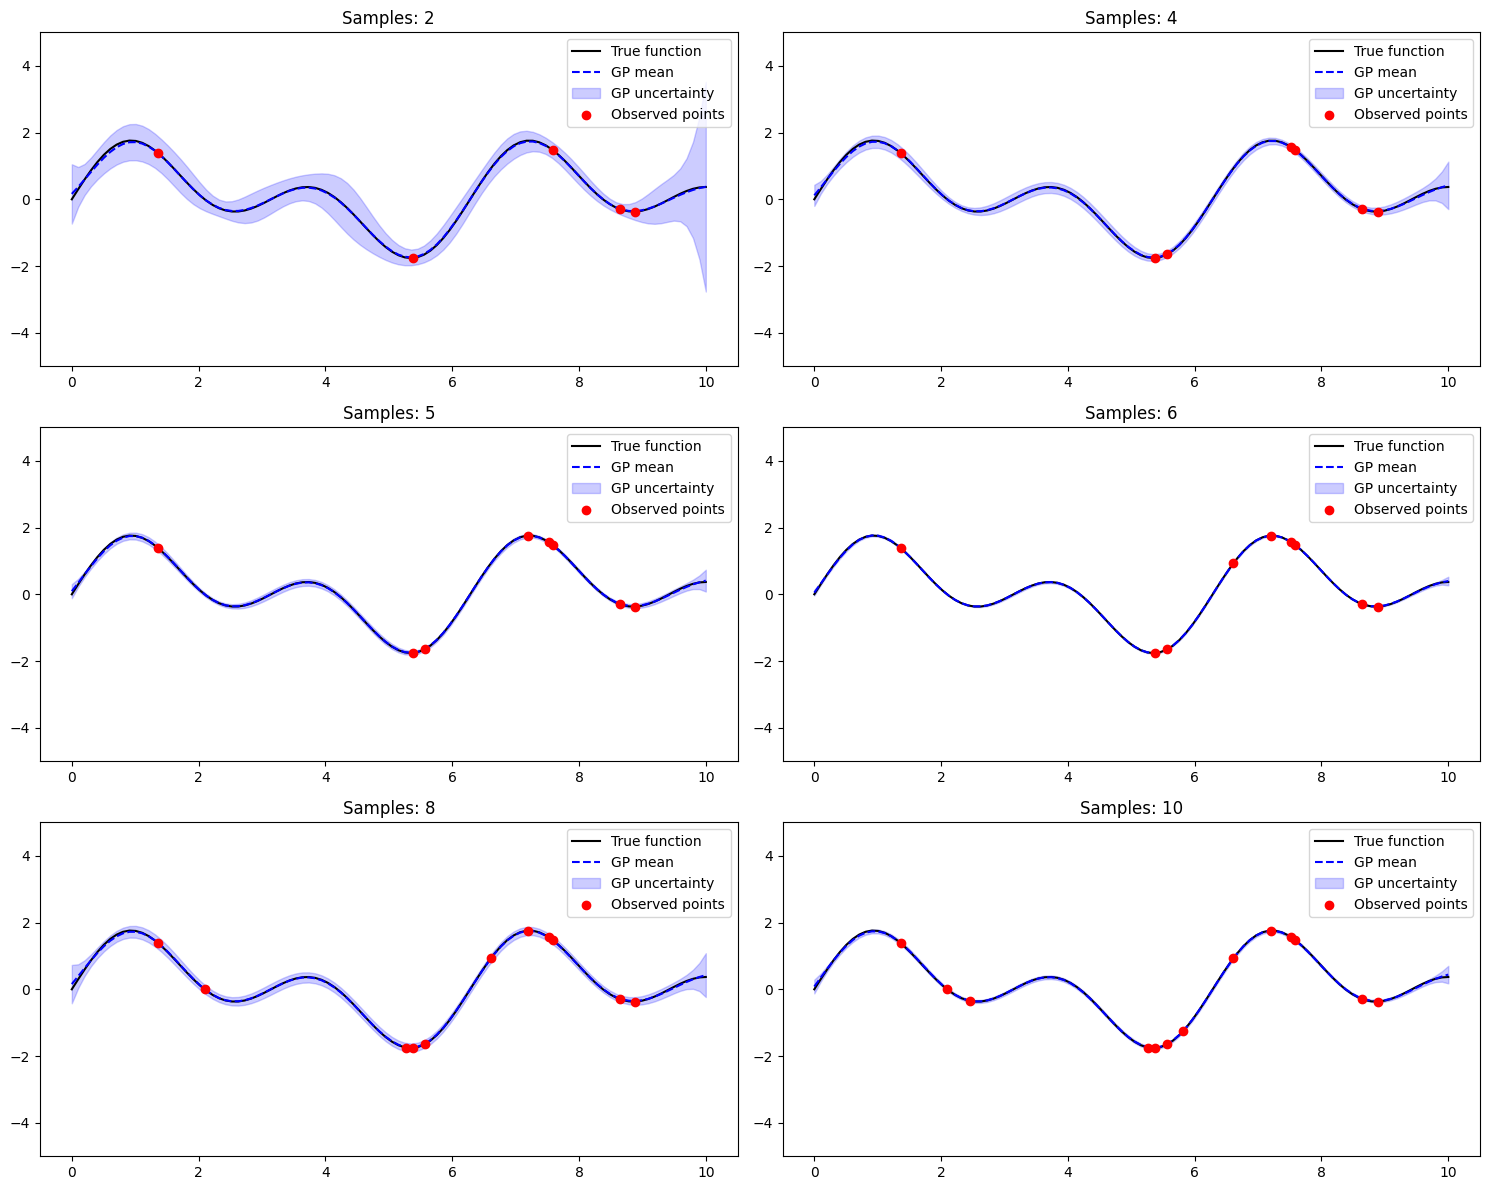

In [15]:
# 绘制子图
plt.figure(figsize=(15, 12))
for i, (pred_mean, pred_std) in enumerate(predictions):
    plt.subplot(3, 2, i+1)
    plt.ylim(-5, 5)
    plt.plot(test_points.numpy(), true_y.numpy(), 'k-', label='True function')
    plt.plot(test_points.numpy(), pred_mean.numpy(), 'b--', label='GP mean')
    plt.fill_between(test_points.numpy().reshape(-1),
                     (pred_mean - 20 * pred_std).numpy().reshape(-1),
                     (pred_mean + 20 * pred_std).numpy().reshape(-1),
                     color='blue', alpha=0.2, label='GP uncertainty')

    observed_x = train_x[:, 0].numpy()  # Only the first dimension for all observed points
    observed_y = train_y.numpy()
    plt.scatter(observed_x[:num_initial_points+key_iterations[i]], observed_y[:num_initial_points+key_iterations[i]], c='r', zorder=3, label='Observed points')
    plt.title(f'Samples: {key_iterations[i]}')
    plt.legend()

plt.tight_layout()
plt.show()
